## Download dataset

In [13]:
# ! นำหน้าใน Notebook แปลว่าให้รันใน Terminal
!pip install kaggle
# !kaggle competitions download -c dog-breed-identification

In [14]:
import os
from google.colab import files

# files.upload()

# dataset = 'diabetic-retinopathy-resized'

# !rm -r $dataset

# !rm -r ~/.kaggle
# !mkdir ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions download -c $dataset

# zip_file = f"{dataset}.zip"
# destination_dir = f"/content/{dataset}"

# if not os.path.exists(zip_file):
#     print(f"Error: {zip_file} not found.")
# else:
#     !unzip -q $zip_file -d $destination_dir
#     !rm $zip_file


In [3]:
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized

Dataset URL: https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized
License(s): unknown
100% 7.25G/7.25G [07:29<00:00, 19.7MB/s]
100% 7.25G/7.25G [07:29<00:00, 17.3MB/s]


In [4]:
# ทำการ unzip .zip ไฟล์ที่ดาวน์โหลดมา
!unzip diabetic-retinopathy-resized.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/resized_train_cropped/resized_train_cropped/44260_right.jpeg  
  inflating: data/resized_train_cropped/resized_train_cropped/44261_left.jpeg  
  inflating: data/resized_train_cropped/resized_train_cropped/44261_right.jpeg  
  inflating: data/resized_train_cropped/resized_train_cropped/44262_left.jpeg  
  inflating: data/resized_train_cropped/resized_train_cropped/44262_right.jpeg  
  inflating: data/resized_train_cropped/resized_train_cropped/44263_left.jpeg  
  inflating: data/resized_train_cropped/resized_train_cropped/44263_right.jpeg  
  inflating: data/resized_train_cropped/resized_train_cropped/44264_left.jpeg  
  inflating: data/resized_train_cropped/resized_train_cropped/44264_right.jpeg  
  inflating: data/resized_train_cropped/resized_train_cropped/44265_left.jpeg  
  inflating: data/resized_train_cropped/resized_train_cropped/44265_right.jpeg  
  inflating: data/resized_train_cropped/resized_train_cropped/4

## **Data cleaning 5class**

In [15]:
!pip install torchvision
!pip install pytorch-lightning

In [16]:
import os
import os.path as op
import shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision import datasets, models, transforms
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [17]:
# get all image paths
img_df = pd.DataFrame(glob("data/resized_train_cropped/resized_train_cropped/*.jpeg"), columns=["path"])
img_df["image"] = img_df.path.map(lambda x: op.basename(x).replace(".jpeg", ""))

# read label data
label_df = pd.read_csv("data/trainLabels_cropped.csv")
train_df = img_df.merge(label_df, on="image")

In [18]:
train_df['level'] = train_df['level'].astype(str)

In [19]:
train_df.head(20)

,path,image,Unnamed: 0.1,Unnamed: 0,level
0,data/resized_train_cropped/resized_train_cropp...,40564_left,32106,32122,0
1,data/resized_train_cropped/resized_train_cropp...,6116_right,4861,4865,0
2,data/resized_train_cropped/resized_train_cropp...,27028_right,21443,21457,2
3,data/resized_train_cropped/resized_train_cropp...,43929_right,34746,34763,2
4,data/resized_train_cropped/resized_train_cropp...,8958_right,7145,7149,0
5,data/resized_train_cropped/resized_train_cropp...,39403_left,31168,31184,2
6,data/resized_train_cropped/resized_train_cropp...,23106_right,18333,18345,0
7,data/resized_train_cropped/resized_train_cropp...,32827_right,25930,25945,0
8,data/resized_train_cropped/resized_train_cropp...,43177_right,34140,34157,0
9,data/resized_train_cropped/resized_train_cropp...,4727_left,3766,3770,0


In [20]:
train_df, validation_df = train_test_split(train_df, test_size=0.2, random_state=3)

In [21]:
print("Length of training set = {}, validation set = {}".format(len(train_df), len(validation_df)))

Length of training set = 28086, validation set = 7022


In [22]:
root_dir = "data/dr_data/"
for df, f in zip([train_df, validation_df], ["train", "validation"]):
    for _, r in df.iterrows():
        # create subfolder if it doesn't exist
        d = op.join(root_dir, f, r.level)
        if not op.exists(d):
            os.makedirs(d)
        shutil.copy(r.path, op.join(root_dir, f, r.level, f"{r.image}.jpg"))

## **Data cleaning 2class**

In [50]:
!pip install torchvision
!pip install pytorch-lightning

In [51]:
import os
import os.path as op
import shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision import datasets, models, transforms
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [52]:
# get all image paths
img_df = pd.DataFrame(glob("data/resized_train_cropped/resized_train_cropped/*.jpeg"), columns=["path"])
img_df["image"] = img_df.path.map(lambda x: op.basename(x).replace(".jpeg", ""))

# read label data
label_df = pd.read_csv("data/trainLabels_cropped.csv")
train_df = img_df.merge(label_df, on="image")

In [53]:
train_df['level'] = train_df['level'].astype(str)

In [54]:
train_df.head(20)

,path,image,Unnamed: 0.1,Unnamed: 0,level
0,data/resized_train_cropped/resized_train_cropp...,40564_left,32106,32122,0
1,data/resized_train_cropped/resized_train_cropp...,6116_right,4861,4865,0
2,data/resized_train_cropped/resized_train_cropp...,27028_right,21443,21457,2
3,data/resized_train_cropped/resized_train_cropp...,43929_right,34746,34763,2
4,data/resized_train_cropped/resized_train_cropp...,8958_right,7145,7149,0
5,data/resized_train_cropped/resized_train_cropp...,39403_left,31168,31184,2
6,data/resized_train_cropped/resized_train_cropp...,23106_right,18333,18345,0
7,data/resized_train_cropped/resized_train_cropp...,32827_right,25930,25945,0
8,data/resized_train_cropped/resized_train_cropp...,43177_right,34140,34157,0
9,data/resized_train_cropped/resized_train_cropp...,4727_left,3766,3770,0


In [55]:
train_df, validation_df = train_test_split(train_df, test_size=0.2, random_state=3)

In [56]:
print("Length of training set = {}, validation set = {}".format(len(train_df), len(validation_df)))

Length of training set = 28086, validation set = 7022


In [58]:
import os
import shutil

root_dir = "data/dr_data/"
for df, f in zip([train_df, validation_df], ["train", "validation"]):
    for _, r in df.iterrows():
        # Determine the folder name based on the level
        folder_name = "0" if r.level == "0" else "1"

        # Create subfolder if it doesn't exist
        d = os.path.join(root_dir, f, folder_name)
        if not os.path.exists(d):
            os.makedirs(d)

        # Copy the image to the corresponding subfolder
        shutil.copy(r.path, os.path.join(d, f"{r.image}.jpg"))


## **Image classification ด้วย Pytorch ล้วนๆ**

In [23]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

In [24]:
# train_transform = T.Compose([
#     T.Resize(256),
#     T.Resize((224,224)),
#     T.ToTensor(),
# ])

# val_transform = T.Compose([
#     T.Resize((224,224)),
#     T.ToTensor(),
# ])

In [25]:
import torch
from torchvision import transforms as T
from PIL import Image
import cv2
import numpy as np

class CustomTransform:
    def __init__(self, img_size):
        self.img_size = img_size

    def __call__(self, img):
        # Convert PIL Image to numpy array
        image = np.array(img)

        # Apply the custom transformations
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), self.img_size / 10), -4, 128)

        # Convert back to PIL Image
        image = Image.fromarray(image)

        return image

# Parameters
IMG_SIZE = 224

# Define the transformation pipelines
train_transform = T.Compose([
    T.Resize(256),
    CustomTransform(img_size=IMG_SIZE),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
])

val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    CustomTransform(img_size=IMG_SIZE),
    T.ToTensor(),
])
# import torch
# from torchvision import transforms as T
# from PIL import Image
# import cv2
# import numpy as np

# class CustomTransform:
#     def __init__(self, img_size):
#         self.img_size = img_size

#     def __call__(self, img):
#         # Convert PIL Image to numpy array
#         image = np.array(img)

#         # Apply the custom transformations in RGB format
#         image = cv2.resize(image, (self.img_size, self.img_size))
#         image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), self.img_size / 10), -4, 128)

#         # Convert back to PIL Image
#         image = Image.fromarray(image)

#         return image

# # Parameters
# IMG_SIZE = 224

# # Define the transformation pipelines
# train_transform = T.Compose([
#     T.Resize(256),
#     CustomTransform(img_size=IMG_SIZE),
#     T.Resize((IMG_SIZE, IMG_SIZE)),
#     T.ToTensor(),
# ])

# val_transform = T.Compose([
#     T.Resize((IMG_SIZE, IMG_SIZE)),
#     CustomTransform(img_size=IMG_SIZE),
#     T.ToTensor(),
# ])


In [26]:
train_data = datasets.ImageFolder("data/dr_data/train/", transform=train_transform)
val_data = datasets.ImageFolder("data/dr_data/validation/", transform=val_transform)

In [27]:
print("Length of training set = {}, validation set = {}".format(len(train_data), len(val_data)))

Length of training set = 33533, validation set = 8443


In [28]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [29]:
n_train = len(train_loader.dataset)
n_val = len(val_loader.dataset)

In [30]:
# ตัวอย่างการโหลดออกมา 1 batch
images, labels = next(iter(train_loader))

In [31]:
# 16 = batch size, 3 = depth, 224 = height, 224 = width
images.shape, labels.shape

(torch.Size([32, 1, 224, 224]), torch.Size([32]))

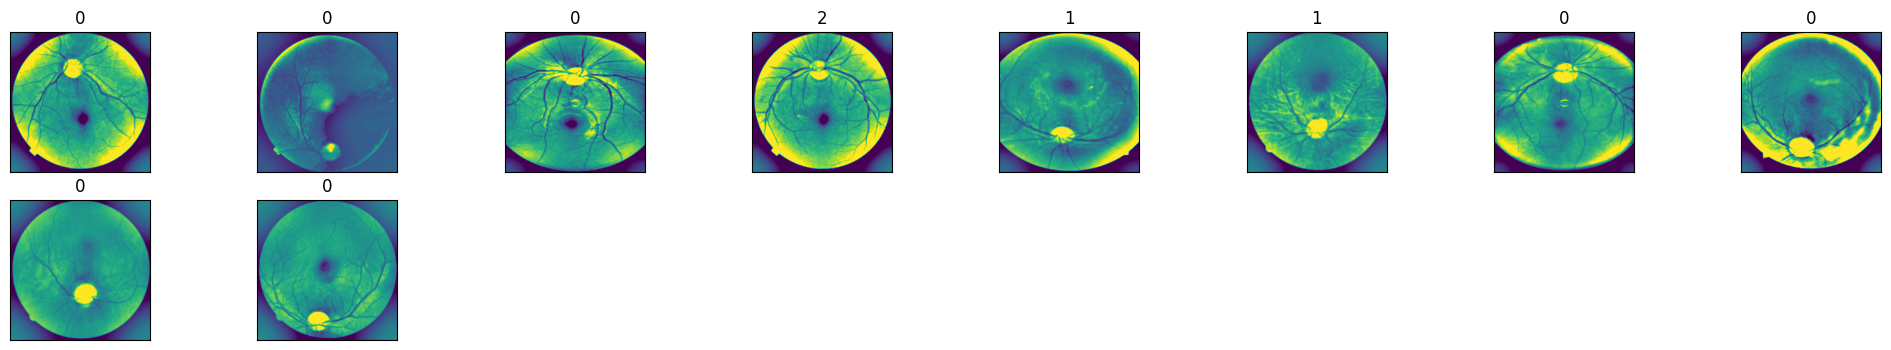

In [32]:
idx2_class = {v: k for k, v in train_data.class_to_idx.items()}
fig = plt.figure(figsize=(25, 4))
for i in range(10):
    image = np.transpose(images.cpu()[i])
    label = idx2_class[labels.cpu().tolist()[i]]
    ax = fig.add_subplot(2, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title(label)

In [33]:
# สร้าง pretrained model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


In [34]:
# เปลี่ยนพารามิเตอร์ใน fc ให้สำหรับทำนายพันธุ์หมาแทน, เช็คก่อนเสมอว่าโมเดลหน้าตาเป็นอย่างไร
model.fc = nn.Linear(in_features=2048, out_features=len(train_data.classes))

In [35]:
# สร้าง loss, optimizer
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2e-3)

In [37]:
# เช็คว่ามี GPU ที่สามารถใช้ได้มั้ย ถ้าใช้ได้นำโมเดลเข้าไปอยู่ใน GPU
gpu = torch.cuda.is_available()
print(gpu)
if gpu:
    model.cuda()

True


In [ ]:
# n_epochs = 10
# for epoch in range(n_epochs):
#     # ช่วง train
#     model.train()
#     train_loss, val_loss = 0, 0
#     for images, labels in tqdm(train_loader):
#         if gpu:
#             images, labels = images.cuda(), labels.cuda()
#         optimizer.zero_grad()
#         pred = model(images) # คำนวณหา output (pred) จาก โมเดลที่มีอยู่
#         loss = cross_entropy(pred, labels)
#         loss.backward() # คำนวณ gradient จาก loss ที่ได้
#         optimizer.step() # อัพเดทพารามิเตอร์ของโมเดล
#         train_loss += loss.item() * images.size(0)

#     # ช่วง validate
#     model.eval() # เซ็ตเป็น evaluation mode
#     for images, labels in tqdm(val_loader):
#         if gpu:
#             images, labels = images.cuda(), labels.cuda()
#         pred = model(images)
#         loss = cross_entropy(pred, labels)
#         val_loss += loss.item() * images.size(0)
#     print("Training loss = {}, Validation loss = {}".format(train_loss / n_train, val_loss / n_val))

In [38]:
# import matplotlib.pyplot as plt

# n_epochs = 1  # Maximum number of epochs
# patience = 10   # Number of epochs to wait without improvement before stopping
# best_val_loss = float('inf')
# epochs_no_improve = 0

# train_losses = []
# val_losses = []

# for epoch in range(n_epochs):
#     # Training phase
#     model.train()
#     train_loss, val_loss = 0, 0
#     for images, labels in tqdm(train_loader):
#         if gpu:
#             images, labels = images.cuda(), labels.cuda()
#         optimizer.zero_grad()
#         pred = model(images)  # Forward pass
#         loss = cross_entropy(pred, labels)
#         loss.backward()  # Backward pass
#         optimizer.step()  # Update parameters
#         train_loss += loss.item() * images.size(0)

#     # Validation phase
#     model.eval()  # Set model to evaluation mode
#     for images, labels in tqdm(val_loader):
#         if gpu:
#             images, labels = images.cuda(), labels.cuda()
#         pred = model(images)
#         loss = cross_entropy(pred, labels)
#         val_loss += loss.item() * images.size(0)

#     train_loss /= n_train
#     val_loss /= n_val

#     train_losses.append(train_loss)
#     val_losses.append(val_loss)

#     print(f"Epoch {epoch + 1}, Training loss = {train_loss:.4f}, Validation loss = {val_loss:.4f}")

#     # Early stopping check
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         epochs_no_improve = 0
#         best_model = model.state_dict()  # Save the best model
#     else:
#         epochs_no_improve += 1

#     if epochs_no_improve >= patience:
#         print(f"Early stopping at epoch {epoch + 1}")
#         break

# # Load the best model
# model.load_state_dict(best_model)

# # Plotting the training and validation losses
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
# plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss Over Epochs')
# plt.legend()
# plt.show()


  0%|          | 0/1048 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[32, 1, 224, 224] to have 3 channels, but got 1 channels instead

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 264/264 [07:10<00:00,  1.63s/it]


Epoch 1, Training loss = 1.0418, Validation loss = 1.0383


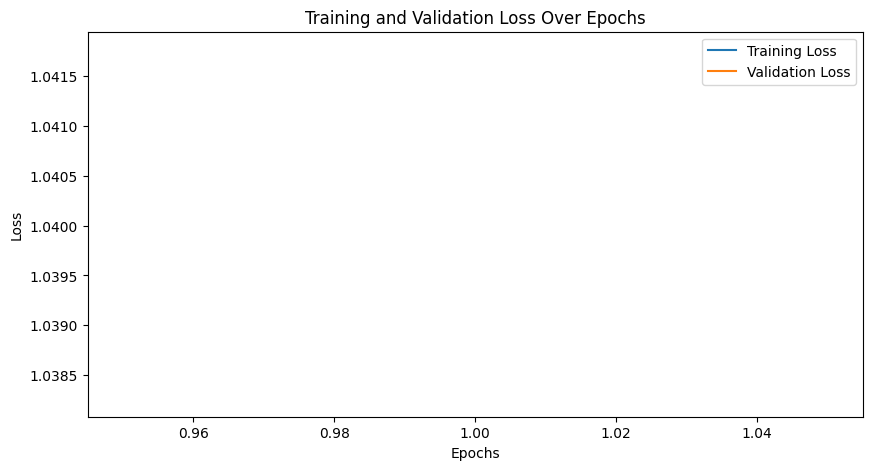

In [39]:
# 1 layer convo
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load pretrained ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify the first convolutional layer to accept grayscale images
model.conv1 = nn.Conv2d(1, model.conv1.out_channels, kernel_size=model.conv1.kernel_size,
                        stride=model.conv1.stride, padding=model.conv1.padding, bias=False)

# Update the final fully connected layer to match the number of classes
num_classes = len(train_data.classes)  # Define your number of classes
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_classes)

# Unfreeze the parameters of the final fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

# GPU support
gpu = torch.cuda.is_available()
if gpu:
    model = model.cuda()

# Define loss function and optimizer
cross_entropy = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=2e-3)

# Training settings
n_epochs = 100  # Maximum number of epochs
patience = 10  # Number of epochs to wait without improvement before stopping
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
val_losses = []

# Example data loaders
# train_loader = DataLoader(...)  # Define your training data loader
# val_loader = DataLoader(...)  # Define your validation data loader

for epoch in range(n_epochs):
    # Training phase
    model.train()
    train_loss, val_loss = 0, 0
    for images, labels in tqdm(train_loader):
        if gpu:
            images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        pred = model(images)  # Forward pass
        loss = cross_entropy(pred, labels)
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters
        train_loss += loss.item() * images.size(0)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    for images, labels in tqdm(val_loader):
        if gpu:
            images, labels = images.cuda(), labels.cuda()
        pred = model(images)
        loss = cross_entropy(pred, labels)
        val_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}, Training loss = {train_loss:.4f}, Validation loss = {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model = model.state_dict()  # Save the best model
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Load the best model
model.load_state_dict(best_model)

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [40]:
# คำนวณหา classification report สำหรับ validation set
y_pred, y_true = [], []
model.eval() # เซ็ตเป็น evaluation mode
for images, labels in tqdm(val_loader):
    if gpu:
        images, labels = images.cuda(), labels.cuda()
    pred = model(images)
    yp = pred.argmax(dim=1).tolist()
    yt = labels.tolist()
    y_pred.extend(yp)
    y_true.extend(yt)
print(classification_report(y_true, y_pred))

100%|██████████| 264/264 [06:59<00:00,  1.59s/it]

              precision    recall  f1-score   support

           0       0.61      1.00      0.75      5110
           1       0.36      0.01      0.02      1912
           2       0.00      0.00      0.00      1106
           3       0.00      0.00      0.00       172
           4       0.00      0.00      0.00       143

    accuracy                           0.61      8443
   macro avg       0.19      0.20      0.16      8443
weighted avg       0.45      0.61      0.46      8443




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
from sklearn.metrics import classification_report
from google.colab import files

y_pred, y_true = [], []
model.eval() # Set the model to evaluation mode
for images, labels in tqdm(val_loader):
    if gpu:
        images, labels = images.cuda(), labels.cuda()
    pred = model(images)
    yp = pred.argmax(dim=1).tolist()
    yt = labels.tolist()
    y_pred.extend(yp)
    y_true.extend(yt)

report = classification_report(y_true, y_pred)

# Save the report to a text file
report_file_path = "classification_report.txt"
with open(report_file_path, "w") as report_file:
    report_file.write(report)

# Download the report file to your local system
files.download("classification_report.txt")


100%|██████████| 264/264 [07:02<00:00,  1.60s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
print("Accuracy on validation set = {}".format(
    accuracy_score(y_true, y_pred))
)

Accuracy on validation set = 0.6053535473173043


In [43]:
print("Precision Recall F1-Score",
      precision_recall_fscore_support(y_true, y_pred, average="micro"))

Precision Recall F1-Score (0.6053535473173043, 0.6053535473173043, 0.6053535473173043, None)


## Test model

In [44]:
import torch

# Directory and file name for saving the model
model_path = '100epoch_normalized.pth'

# Save the best model
torch.save(best_model, model_path)  # Save the best model state dictionary to a file

# Load the best model
model.load_state_dict(torch.load(model_path))  # Load the best model state dictionary from the file


<All keys matched successfully>

In [46]:
!unzip Store_Set.zip -d ODocs_data

Archive:  Store_Set.zip
   creating: ODocs_data/Store Set/Montage 1/
  inflating: ODocs_data/Store Set/Montage 1/1.JPG  
  inflating: ODocs_data/Store Set/Montage 1/2.JPG  
  inflating: ODocs_data/Store Set/Montage 1/3.JPG  
  inflating: ODocs_data/Store Set/Montage 1/4.JPG  
  inflating: ODocs_data/Store Set/Montage 1/5.JPG  
  inflating: ODocs_data/Store Set/Montage 1/6.JPG  
  inflating: ODocs_data/Store Set/Montage 1/7.JPG  
  inflating: ODocs_data/Store Set/Montage 1/8.JPG  
  inflating: ODocs_data/Store Set/Montage 1/9.JPG  
  inflating: ODocs_data/Store Set/Montage 1/montage 1.jpg  
   creating: ODocs_data/Store Set/Montage 2/
  inflating: ODocs_data/Store Set/Montage 2/1.JPG  
  inflating: ODocs_data/Store Set/Montage 2/10.JPG  
  inflating: ODocs_data/Store Set/Montage 2/11.JPG  
  inflating: ODocs_data/Store Set/Montage 2/12.JPG  
  inflating: ODocs_data/Store Set/Montage 2/2.JPG  
  inflating: ODocs_data/Store Set/Montage 2/3.JPG  
  inflating: ODocs_data/Store Set/Montage 2

In [49]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.nn import functional as F
from PIL import Image
import os
import csv

# Function to load the model
def load_model(model_path, num_classes):
    model = resnet50(pretrained=False)

    # Adjust the first convolutional layer if the model was trained on grayscale images
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    # Modify the fc layer to match the number of classes in the trained model
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

# Function to preprocess the image
def preprocess_image(image_path):
    input_transforms = transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256 pixels
        transforms.CenterCrop(224),  # Crop the center 224x224 pixels
        transforms.ToTensor(),  # Convert the image to a tensor
        # Remove normalization if the model was not trained with normalized images
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
    ])
    image = Image.open(image_path).convert('L')  # Open the image and convert to grayscale
    return input_transforms(image).unsqueeze(0)  # Add batch dimension

# Function to get the predictions
def get_predictions(model, image_tensor):
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(image_tensor)
    return outputs

# Function to get the predicted class and probabilities
def interpret_predictions(logits):
    probabilities = F.softmax(logits, dim=1)
    predicted_class = probabilities.argmax(dim=1)
    return predicted_class, probabilities

# Main function to process the images in all subfolders
def process_images_in_folders(model_path, main_folder, num_classes, output_csv_path):
    model = load_model(model_path, num_classes)

    # Open the CSV file for writing
    with open(output_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Subfolder', 'Image', 'Predicted Class'])

        # Walk through all subfolders
        for subfolder in os.listdir(main_folder):
            subfolder_path = os.path.join(main_folder, subfolder)
            if os.path.isdir(subfolder_path):
                image_files = [f for f in os.listdir(subfolder_path) if f.endswith(('jpg', 'jpeg', 'png', 'JPG'))]

                for image_file in image_files:
                    image_path = os.path.join(subfolder_path, image_file)
                    image_tensor = preprocess_image(image_path)
                    logits = get_predictions(model, image_tensor)
                    predicted_class, probabilities = interpret_predictions(logits)

                    # Write the result to the CSV file
                    writer.writerow([subfolder, image_file, predicted_class.item()])

                    # Print the results
                    print(f'Predictions for {image_file} in {subfolder}:')
                    print(f'    Logits: {logits}')
                    print(f'    Probabilities: {probabilities}')
                    print(f'    Predicted class: {predicted_class}')

# Example usage
model_path = '/content/100epoch_normalized.pth'
main_folder = '/content/ODocs_data/Store Set'  # This is the main folder containing multiple subfolders
num_classes = 5  # Adjust this based on your trained model
output_csv_path = '/content/predictions.csv'

process_images_in_folders(model_path, main_folder, num_classes, output_csv_path)


Predictions for 6.JPG in Montage 7:
    Logits: tensor([[ 2.0063,  0.8454,  0.0701, -2.0663, -2.1473]])
    Probabilities: tensor([[0.6710, 0.2102, 0.0968, 0.0114, 0.0105]])
    Predicted class: tensor([0])
Predictions for 17.JPG in Montage 7:
    Logits: tensor([[ 2.1627,  0.8169,  0.0215, -2.0557, -2.1029]])
    Probabilities: tensor([[0.7109, 0.1851, 0.0835, 0.0105, 0.0100]])
    Predicted class: tensor([0])
Predictions for 4.JPG in Montage 7:
    Logits: tensor([[ 2.0179,  0.7437,  0.1044, -2.0430, -2.2321]])
    Probabilities: tensor([[0.6855, 0.1917, 0.1012, 0.0118, 0.0098]])
    Predicted class: tensor([0])
Predictions for 14.JPG in Montage 7:
    Logits: tensor([[ 2.1069,  0.9080,  0.1694, -1.7427, -1.9492]])
    Probabilities: tensor([[0.6738, 0.2032, 0.0971, 0.0143, 0.0117]])
    Predicted class: tensor([0])
Predictions for 16.JPG in Montage 7:
    Logits: tensor([[ 1.7672,  1.1203, -0.1046, -2.0061, -2.0413]])
    Probabilities: tensor([[0.5805, 0.3040, 0.0893, 0.0133, 0.012

In [48]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.nn import functional as F
from PIL import Image
import os
import csv

# Function to load the model
def load_model(model_path, num_classes):
    model = resnet50(pretrained=False)
    # Modify the fc layer to match the number of classes in the trained model
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model

# Function to preprocess the image
def preprocess_image(image_path):
    input_transforms = transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256 pixels
        transforms.CenterCrop(224),  # Crop the center 224x224 pixels
        transforms.ToTensor(),  # Convert the image to a tensor
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
    ])
    image = Image.open(image_path).convert('RGB')  # Open the image and convert to RGB
    return input_transforms(image).unsqueeze(0)  # Add batch dimension

# Function to get the predictions
def get_predictions(model, image_tensor):
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(image_tensor)
    return outputs

# Function to get the predicted class and probabilities
def interpret_predictions(logits):
    probabilities = F.softmax(logits, dim=1)
    predicted_class = probabilities.argmax(dim=1)
    return predicted_class, probabilities

# Main function to process the images in all subfolders
def process_images_in_folders(model_path, main_folder, num_classes, output_csv_path):
    model = load_model(model_path, num_classes)

    # Open the CSV file for writing
    with open(output_csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Subfolder', 'Image', 'Predicted Class'])

        # Walk through all subfolders
        for subfolder in os.listdir(main_folder):
            subfolder_path = os.path.join(main_folder, subfolder)
            if os.path.isdir(subfolder_path):
                image_files = [f for f in os.listdir(subfolder_path) if f.endswith(('jpg', 'jpeg', 'png', 'JPG'))]

                for image_file in image_files:
                    image_path = os.path.join(subfolder_path, image_file)
                    image_tensor = preprocess_image(image_path)
                    logits = get_predictions(model, image_tensor)
                    predicted_class, probabilities = interpret_predictions(logits)

                    # Write the result to the CSV file
                    writer.writerow([subfolder, image_file, predicted_class.item()])

                    # Print the results
                    print(f'Predictions for {image_file} in {subfolder}:')
                    print(f'    Logits: {logits}')
                    print(f'    Probabilities: {probabilities}')
                    print(f'    Predicted class: {predicted_class}')

# Example usage
model_path = '/content/100epoch_normalized.pth'
main_folder = '/content/ODocs_data/Store Set'  # This is the main folder containing multiple subfolders
num_classes = 2  # Adjust this based on your trained model
output_csv_path = '/content/predictions.csv'

process_images_in_folders(model_path, main_folder, num_classes, output_csv_path)


RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 1, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 3, 7, 7]).
	size mismatch for fc.weight: copying a param with shape torch.Size([5, 2048]) from checkpoint, the shape in current model is torch.Size([2, 2048]).
	size mismatch for fc.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([2]).